<a href="https://colab.research.google.com/github/rmr327/BtcDrivers/blob/main/BitcoinDrivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References

https://github.com/nogibjj/Flamingo-ML

https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main/explainable-ml-example-notebooks

I used ChatGPT 3.5 to rephrase some text.

I used google gemini for code complettion.

## Overview

In this exercise, our goal is to utilize a Random Forest model to forecast directional changes in Bitcoin prices (will the price tomorrow go up or down). We will employ explainable AI methods to gain insights: both local (ICE plots) and global (PDP & ALE plots) explanations will be explored for our model. Our objective is to understand how each feature in our final model impacts Bitcoin price movements for the next day. To enhance the accuracy of our model during training, we opted to use the 15-day moving average price (15DAR) as the response variable rather than the raw closing price. Previous findings from our project demonstrate that 15DAR effectively predicts Bitcoin price movements.

## Load the necesary libraries

In [2]:
# !pip install sweetviz
# !pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

import pandas as pd
import matplotlib.dates as mdates
import sweetviz as sv
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot

# Set the style of seaborn
sns.set_style("darkgrid")

# copy without warnings
pd.options.mode.chained_assignment = None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 70.9 MB/s eta 0:00:00
  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-ne1oodc1/alepython_8709d5e9b3ef4a00ac22817fc4626568
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-ne1oodc1/alepython_8709d5e9b3ef4a00ac22817fc4626568
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=b22e0bf2d678df6f39ad449641ba17f849e335ea1be40081b1b2bf64cf19db14
  Stored in directory: /tmp/pip-ephem-wheel-cache-8pouu9ok/wheels/80/2e/91/7f216caef9a7f0c6ce18ee562b6156df43b3a79f69a0c1f3d1
Successfully built alepython


## Load & Clean data (Feature definitions provided after feature selection below)

> Loading dataset used in an old project, where we made a random forest model to predict if Bitcoin Price will go up or down the following day based on a predicted 15 day moving average price.

In [3]:
data = pd.read_csv(r"https://raw.githubusercontent.com/nogibjj/Flamingo-ML/refs/heads/main/Data/Aggregated_Final_Lin_Rakeen_Fixed_returns.csv")

# drop magnitude and Direction columns
data = data.drop(columns=["magnitude", "Direction"])

data.set_index("date_dt", inplace=True)
data.index = pd.to_datetime(data.index)

split_date = "2023-03-01" # date to split training and testing data
daily_test_returns = data[data.index >= split_date]["Daily Return"]
daily_close = data[data.index >= split_date]["Close"].shift(-1)
daily_open = data[data.index >= split_date]["Open"].shift(-1)

# convert return to moving average
data["Daily_Return_rolling_15_avg"] = data["Daily Return"].rolling(window=15).mean()
data.dropna(inplace=True)

# drop original return column
data = data.drop(columns=["Daily Return"])

data.head()

positive_count_bitcoin  negative_count_bitcoin  \
date_dt                                                      
2021-05-06                     0.0                     1.0   
2021-05-07                     0.0                     1.0   
2021-05-08                     0.0                     1.0   
2021-05-09                     0.0                     1.0   
2021-05-10                     2.0                     1.0   

            neutral_count_bitcoin  positive_avg_score_bitcoin  \
date_dt                                                         
2021-05-06                    2.0                    0.000000   
2021-05-07                    2.0                    0.000000   
2021-05-08                    2.0                    0.000000   
2021-05-09                    2.0                    0.000000   
2021-05-10                    0.0                    0.869209   

            negative_avg_score_bitcoin  neutral_avg_score_bitcoin  \
date_dt                                                             
2021-05-06                    0.827074                   0.900657   
2021-05-07                    0.827074                   0.900657   
2021-05-08                    0.827074                   0.900657   
2021-05-09                    0.827074                   0.900657   
2021-05-10                    0.913061                   0.000000   

            total_news_count_bitcoin  total_news_score_bitcoin  \
date_dt                                                          
2021-05-06                       3.0                 -0.827074   
2021-05-07                       3.0                 -0.827074   
2021-05-08                       3.0                 -0.827074   
2021-05-09                       3.0                 -0.827074   
2021-05-10                       3.0                  0.825356   

            signal_bitcoin  TWITTER_SENTIMENT_DAILY_AVG  ...  T5YIE_lag1  \
date_dt                                                  ...               
2021-05-06       -1.000000                      -0.0058  ...        2.62   
2021-05-07       -1.000000                      -0.0075  ...        2.68   
2021-05-08       -1.000000                      -0.0228  ...        2.66   
2021-05-09       -1.000000                      -0.0228  ...        2.65   
2021-05-10        0.333333                      -0.0228  ...        2.65   

            T5YIE_lag2  S&P500_Close_lag1  S&P500_Close_lag2  VIX_Close_lag1  \
date_dt                                                                        
2021-05-06        2.60        4164.660156        4192.660156       19.480000   
2021-05-07        2.62        4167.589844        4164.660156       19.150000   
2021-05-08        2.68        4201.620117        4167.589844       18.389999   
2021-05-09        2.66        4232.600098        4201.620117       16.690001   
2021-05-10        2.65        4232.600098        4232.600098       16.690001   

            VIX_Close_lag2  S&P_Return_lag1  S&P_Return_lag2  gg_trend  \
date_dt                                                                  
2021-05-06       18.309999        -0.006678         0.002748  0.122346   
2021-05-07       19.480000         0.000703        -0.006678  0.122346   
2021-05-08       19.150000         0.008165         0.000703  0.122346   
2021-05-09       18.389999         0.007373         0.008165  0.105151   
2021-05-10       16.690001         0.000000         0.007373  0.105151   

            Daily_Return_rolling_15_avg  
date_dt                                  
2021-05-06                     0.003011  
2021-05-07                     0.006842  
2021-05-08                     0.009370  
2021-05-09                     0.010093  
2021-05-10                     0.008729  

[5 rows x 66 columns]

## Train, Evaluate & Plot


> The function below is used to train and evaluate random forest models. We will be using this function to train an initial Random forest model with all features. Then train a reduced model with the top 10 most influential features. Ultimately we will use ICE, PDP & ALE plots to understand how each of these features affect our models predictions.

In [4]:
def train_evaluate_and_plot(X_train, y_train, X_test, y_test, daily_close, plot_title):
    """Train, evaluate and plot a random forest model."""
    model = RandomForestRegressor()
    # fit model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # evaluate model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    r_squared = model.score(X_test, y_test)
    print(f"R Squared: {r_squared}")

    # make a dataframe with y_test and y_pred
    results = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

    # compute residuals
    results["residuals"] = results["y_test"] - results["y_pred"]

    # Set the style of seaborn
    sns.set_style("darkgrid")

    # plot results
    plt.figure(figsize=(15, 8))
    plt.plot(results["y_test"], label="Actual_15DAR", linewidth=2)
    plt.plot(results["y_pred"], label="Predicted_15DAR", linewidth=2)
    plt.legend(loc="upper center")
    plt.title(plot_title, fontsize=16)
    plt.xticks(rotation=90)
    days_fmt = mdates.DateFormatter("%Y-%m-%d")
    plt.gca().xaxis.set_major_formatter(days_fmt)
    # Set x-axis major ticks to occur every 15 days.
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.ylabel("BTC Returns (percentage change)", fontsize=14)

    # plot the close price on the same graph on the right axis
    ax2 = plt.twinx()
    ax2.plot(daily_close, color="red", label="Close", linewidth=2)
    ax2.legend(loc="upper left")
    ax2.set_ylabel("BTC Close Price (USD)", fontsize=14)

    plt.xticks(rotation=90)
    plt.show()

    # feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    # print("Feature ranking:")
    # for f in range(X_train.shape[1]):
    #     print(f"{f + 1}. {X_train.columns[indices[f]]} ({importances[indices[f]]})")

    if X_train.shape[1] < 20:
      # Plot the feature importances of the forest
      plt.figure(figsize=(15, 8))
      plt.title("Feature importances", fontsize=16)
      plt.bar(
          range(X_train.shape[1]), importances[indices], align="center", color="skyblue"
      )
      plt.xticks(range(X_train.shape[1]), np.array(X_train.columns)[indices], rotation=90)
      plt.xlim([-1, X_train.shape[1]])

      plt.show()

    return model, results

> Full model with all features

Mean Squared Error: 1.0941099723806074e-05
R Squared: 0.7406908301184052


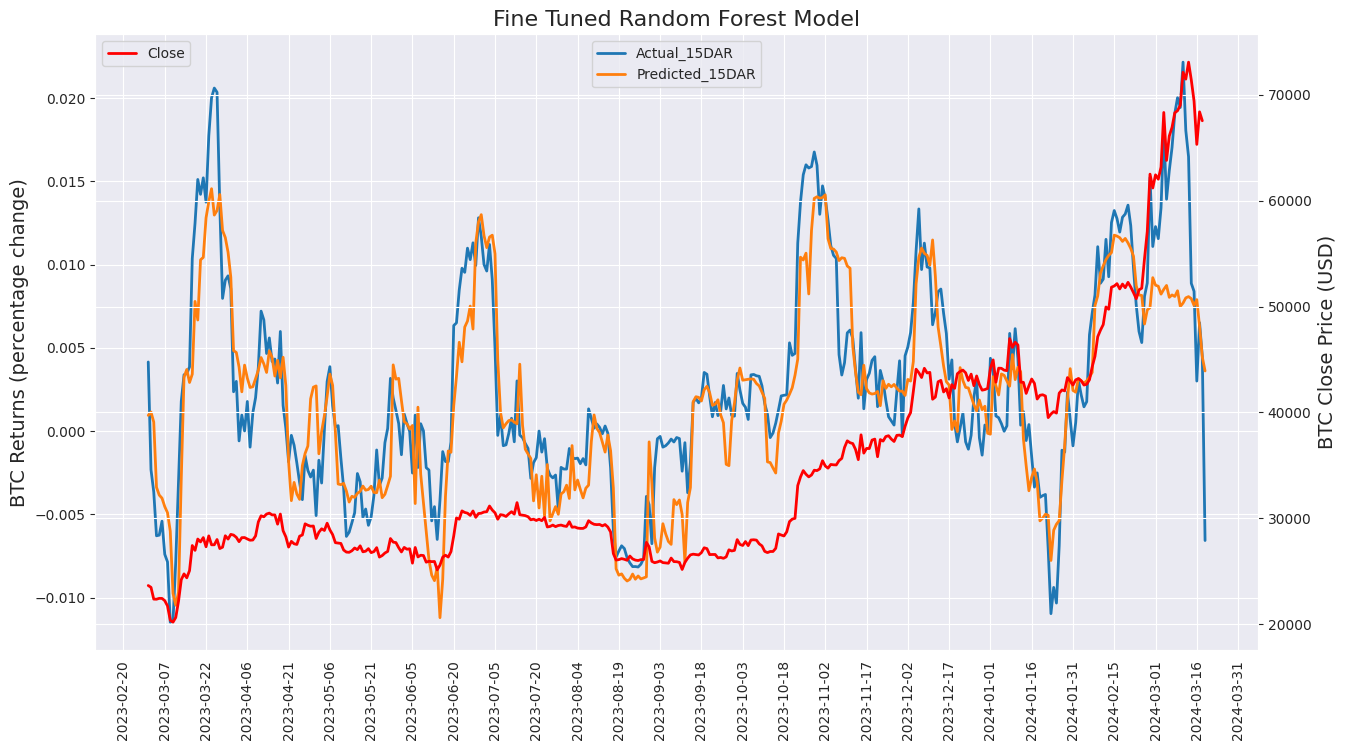

In [5]:
# Define the number of lags
n_lags = 3
split_date = "2023-03-01"

# Create a new DataFrame for lagged features
lagged_features = []
lagged_features_cols = []

data = data.dropna(subset=["Daily_Return_rolling_15_avg"])

X_now = data.drop(
    columns=[
        "Daily_Return_rolling_15_avg"
    ]
)
y_now = data["Daily_Return_rolling_15_avg"]

# Create lagged versions of features
for column in X_now.columns:
    for lag in range(1, n_lags + 1):
        lagged_features.append(X_now[column].rolling(lag * 10).sum())
        lagged_features_cols.append(f"{column}_rolling_{lag * 10}")

lagged_features = pd.concat(lagged_features, axis=1)
lagged_features.columns = lagged_features_cols

# Concatenate the original DataFrame with the DataFrame of lagged features
X_now = pd.concat([X_now, lagged_features], axis=1)

# Drop rows with NaN values caused by lagging in both X and y
X_now = X_now.dropna()
y_now = y_now[X_now.index]

# Split the data again after creating lagged features
X_train = X_now[X_now.index < split_date]
X_test = X_now[X_now.index >= split_date]
y_train = y_now[y_now.index < split_date]
y_test = y_now[y_now.index >= split_date]

# Train, evaluate, and plot the model
model, results = train_evaluate_and_plot(
    X_train, y_train, X_test, y_test, daily_close, "Fine Tuned Random Forest Model"
)

The full model explains about 74% of the variance in Bitcoin prices in our test set.

> Random forest model with top 10 important features.

Mean Squared Error: 1.0318999794812319e-05
R Squared: 0.7554348887818841


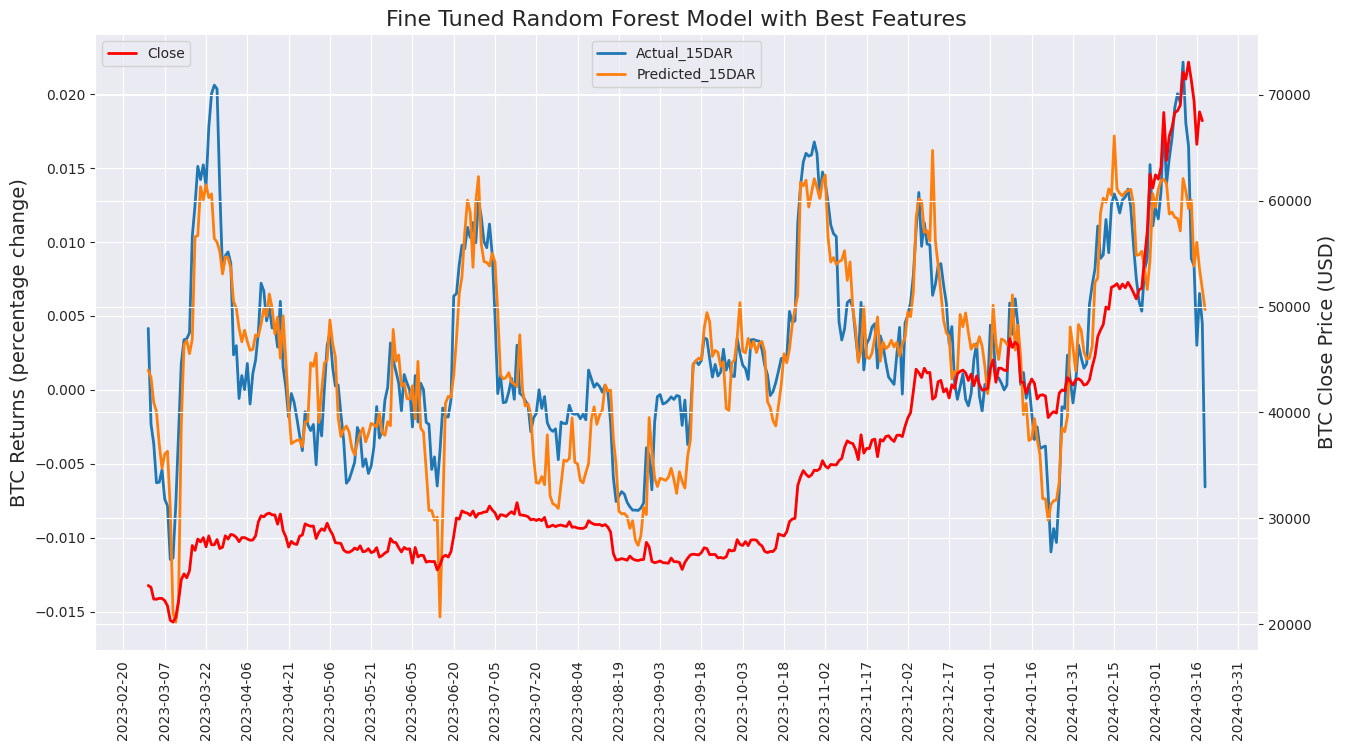

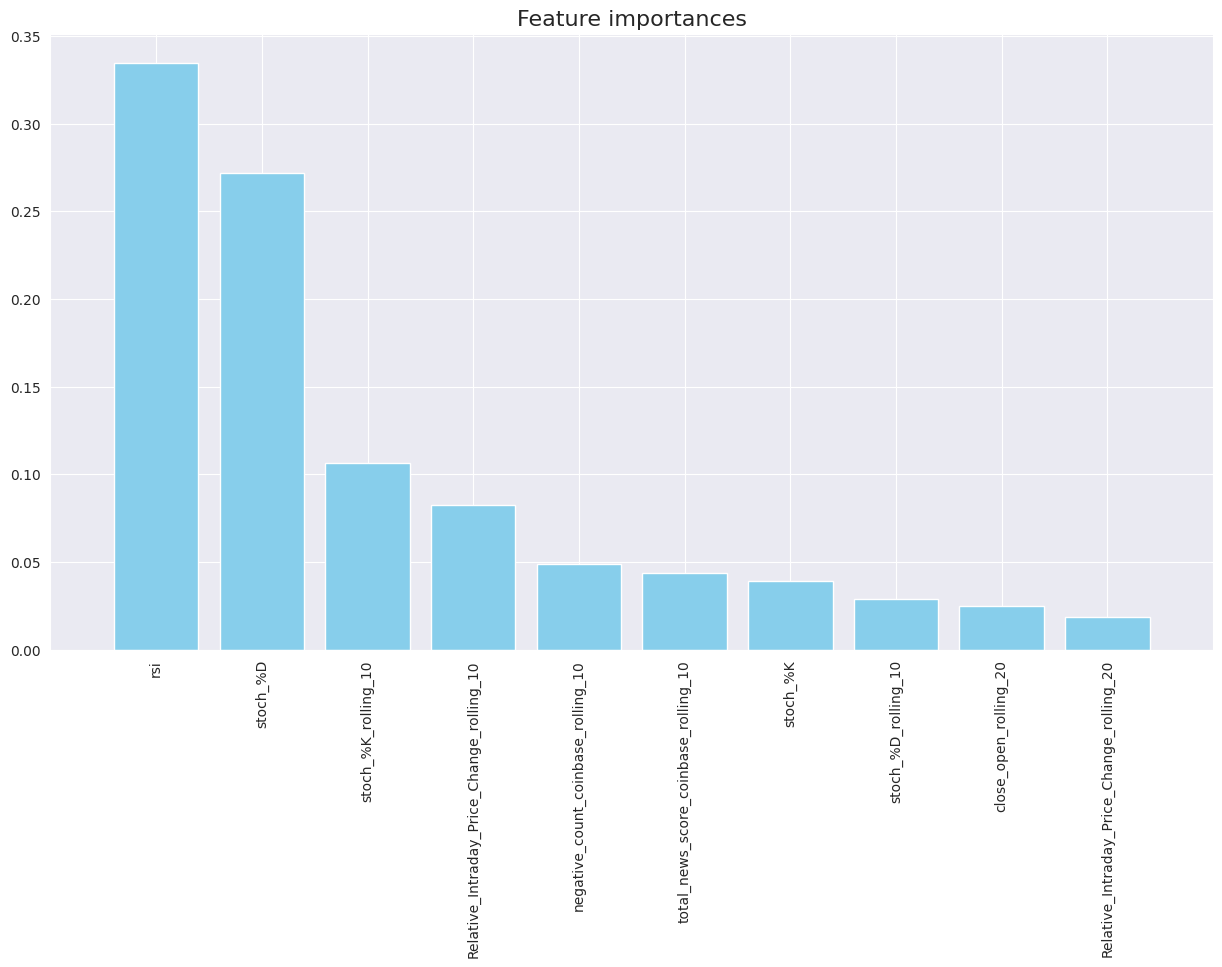

In [6]:
# make another model with best features from the above random forest model
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
cols = np.array(X_train.columns)[indices][:10]
X = X_now[cols]
y = y_now

split_date = "2023-03-01"
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

model, results = train_evaluate_and_plot(
    X_train,
    y_train,
    X_test,
    y_test,
    daily_close,
    "Fine Tuned Random Forest Model with Best Features",
)

The reduced model explains about 75% of the variance in Bitcoin prices in our test set.

> Final feature definitions

| Feature Name                                   | Definition                                                                         |
|-----------------------------------------------|------------------------------------------------------------------------------------|
| RSI                                           | Relative Strength Index for Bitcoin, a momentum indicator measuring the speed and change of price movements |
| stoch_%D                                      | Stochastic oscillator %D value for Bitcoin |
| stoch_%K_rolling_10                           | Stochastic oscillator %K value for Bitcoin, summed over a rolling 10 day window              |
| Relative_Intraday_Price_Change_rolling_10     | Relative change in intraday price summed over a 10 day rolling window                  |
| stoch_%K                                      | Stochastic oscillator %K value for Bitcoin |
| negative_count_coinbase_rolling_10            | Number of negative news mentions about Coinbase summed over a 10 day rolling window    |
| Relative_Intraday_Price_Change_rolling_10     | Relative change in intraday price summed over a 10-period rolling window                  |
| stoch_%D_rolling_10                           | Stochastic oscillator %D value for Bitcoin, summed over a rolling 10 day window              |
| total_news_score_coinbase_rolling_10          | Aggregate score of news sentiment about Coinbase summed over a 10-period rolling window   |
| close_open_rolling_20                         | Difference between closing and opening prices summed over a 20-period rolling window      |


> Automated EDA generation

In [7]:
# concat X & Y
data_final = pd.concat([X, y], axis=1)

report = sv.analyze(data_final)

# save report
report.show_html("btc_eda_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report btc_eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


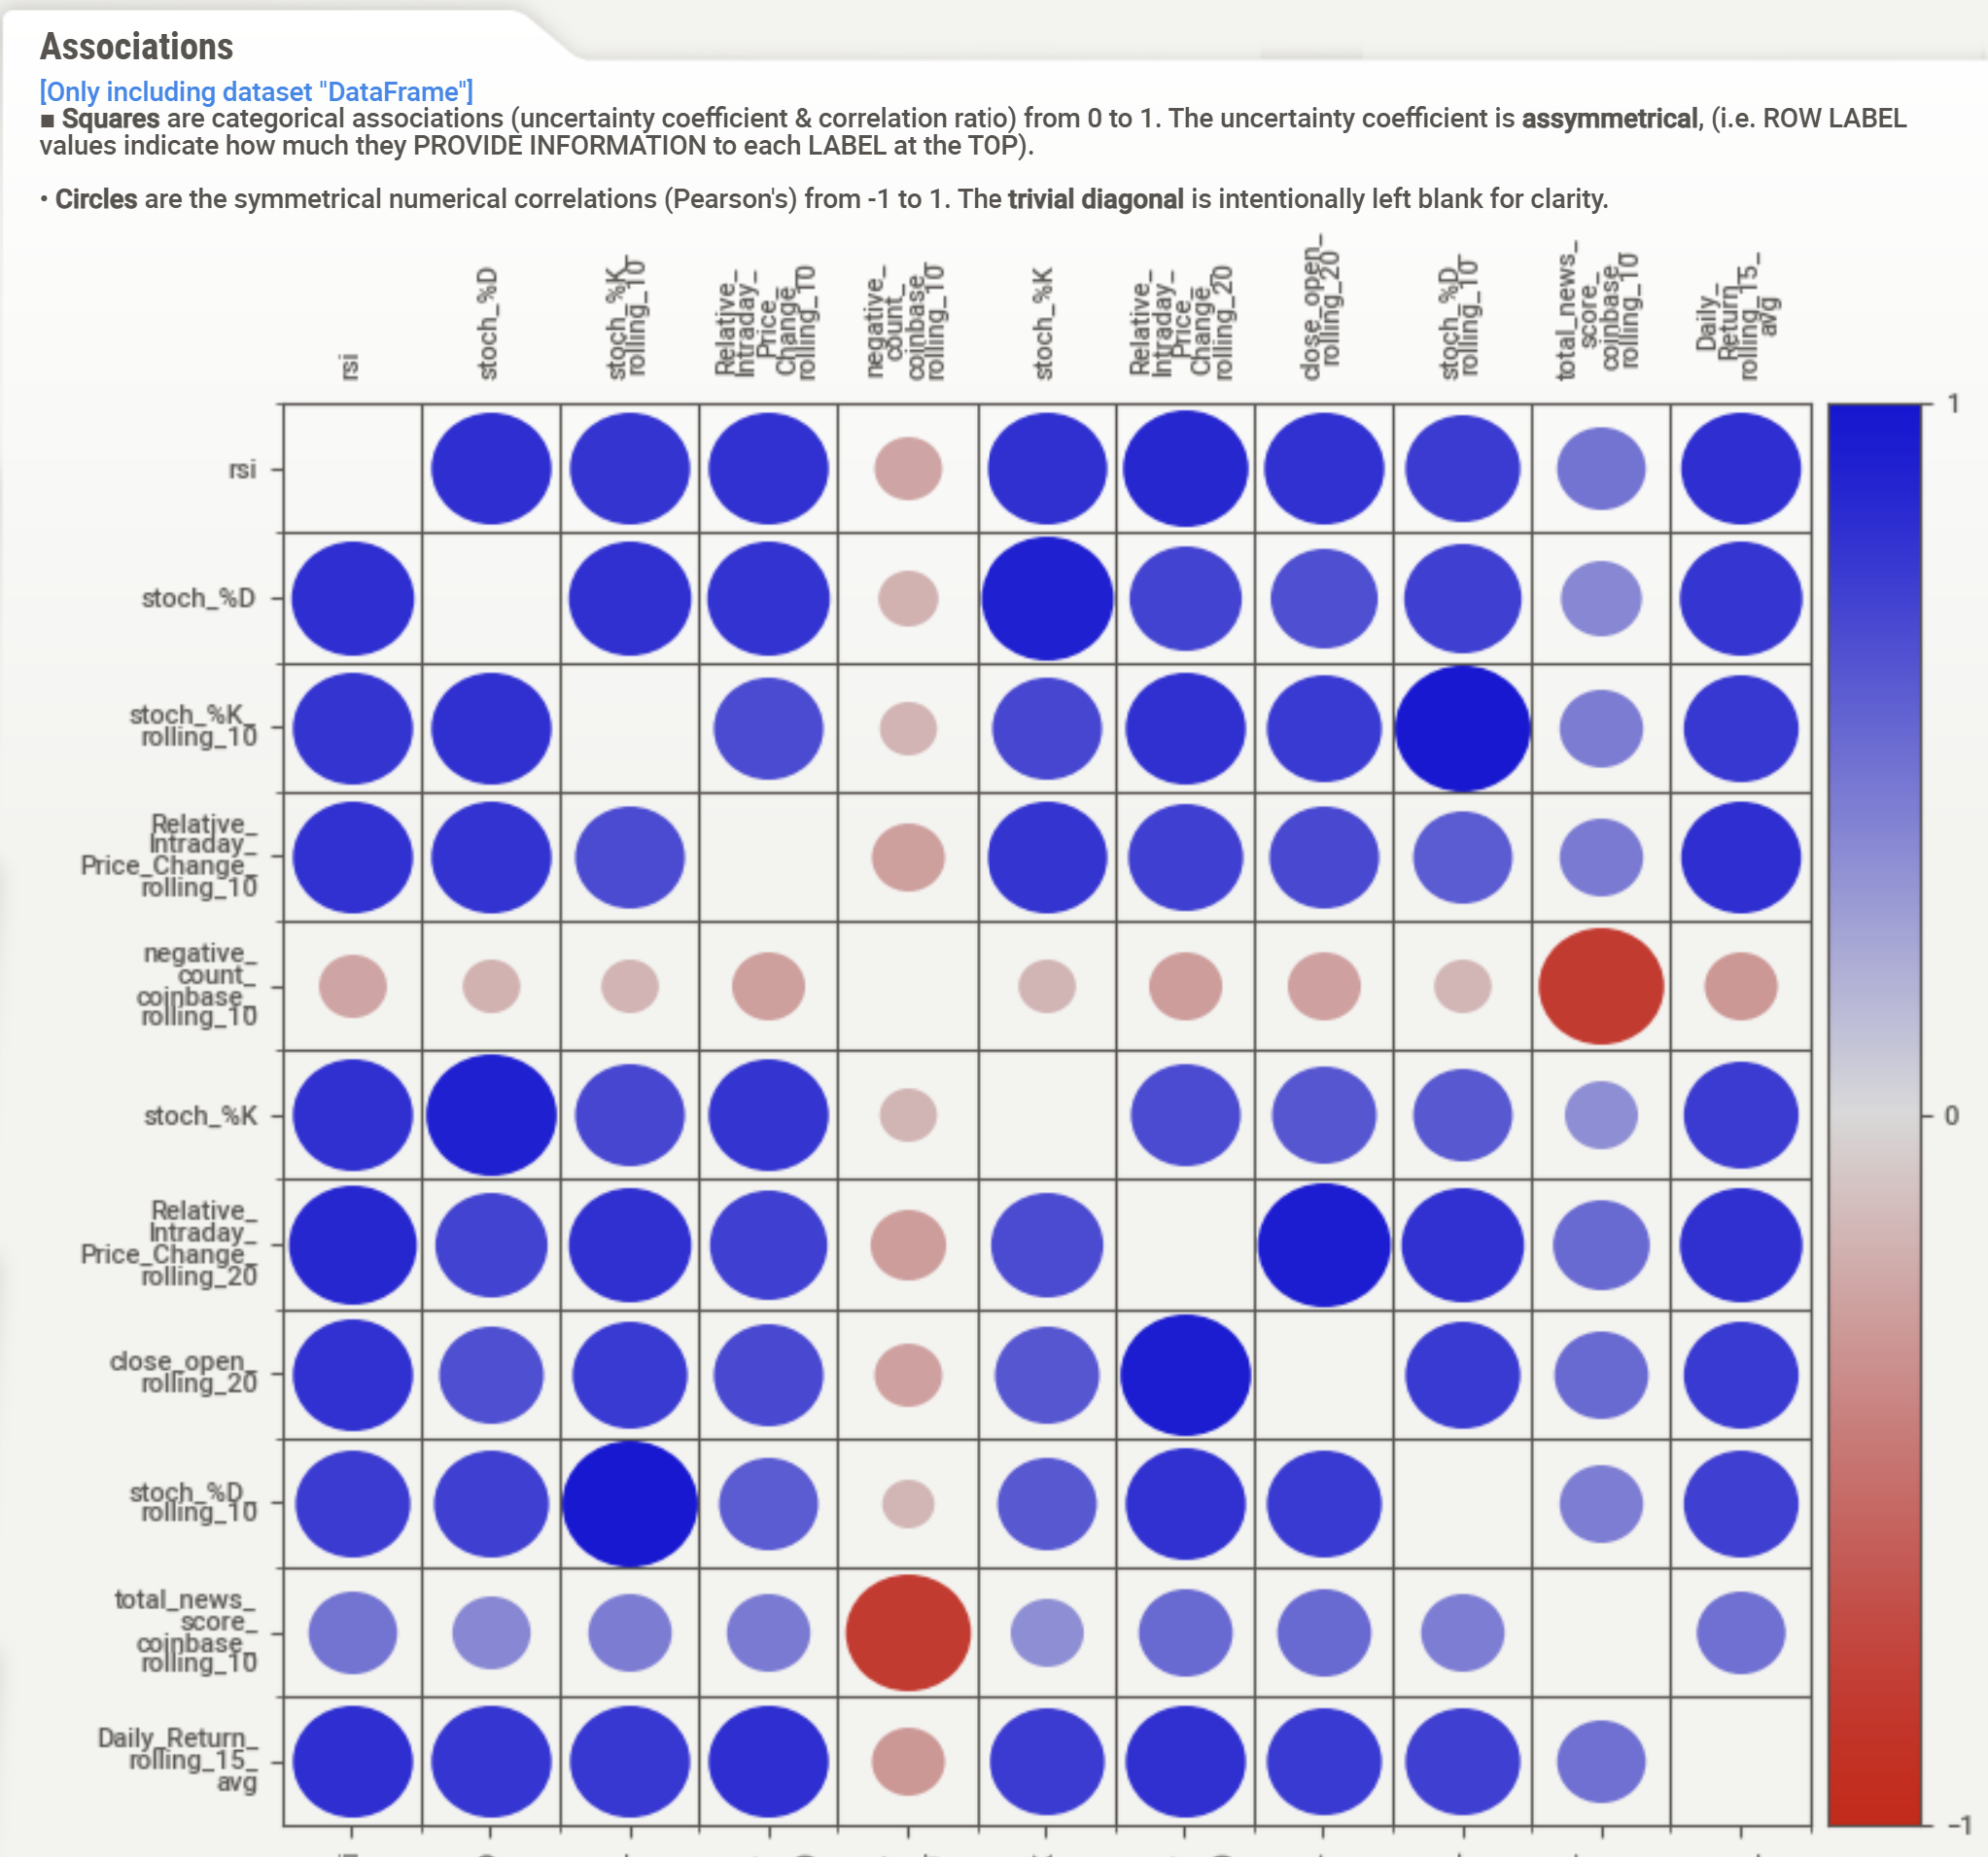

The correlation matrix above shows that all the features are somewhat correlated. This is anticipated, given the complexity of predicting BTC prices, which involves multiple nonlinearities and interactions among the features. Due to the high correlation among the features, using ICE and PDP plots may lead to biased or inaccurate assessments of the relationships between individual features and BTC price movements. ALE plots will most likely give a more true representation of the relationship between the individual features and tomorrows Bitcoin price.

## ICE (Individual Conditional Expectation) & PDP (Partial Dependance) Plots

> WARNING!! Since the features have high multicollinearity, the plots in this section might not give an accurate representation of how the individual features affect Bitcoin prices. This happens because PDP & ICE methods assume that the features are independent.

**ICE Plots**

ICE plots show us how a chosen feature affects the prediction of our model. For example, if we want to see how the relative strength index (RSI) of Bitcoin affects the price, we will change the RSI for each data point and observe how the predicted price changes, keeping all other features constant. In the graphs below the blue lines represent the ICE plots for every observation in our dataset.

**PDP Plots**

PDP plots are just an average of all the ICE plots (all the blue lines below). In the graphs below, the orange dashed lines represent the PDP plots.


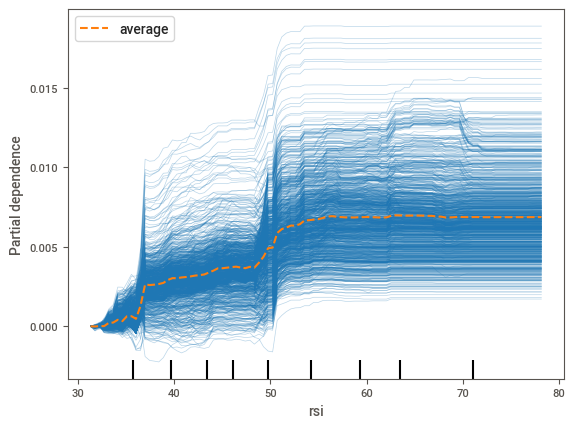

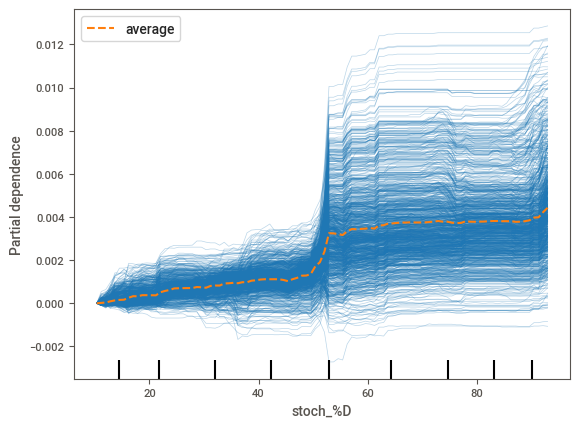

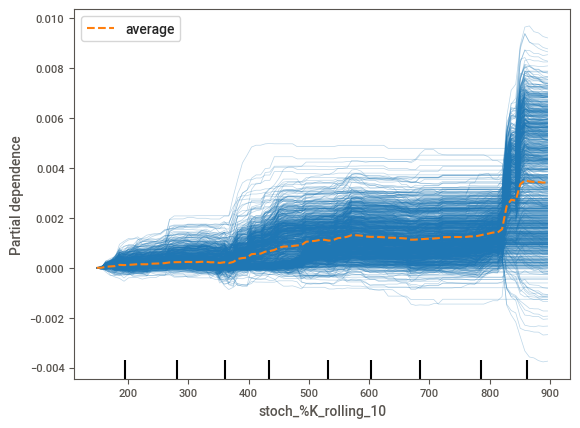

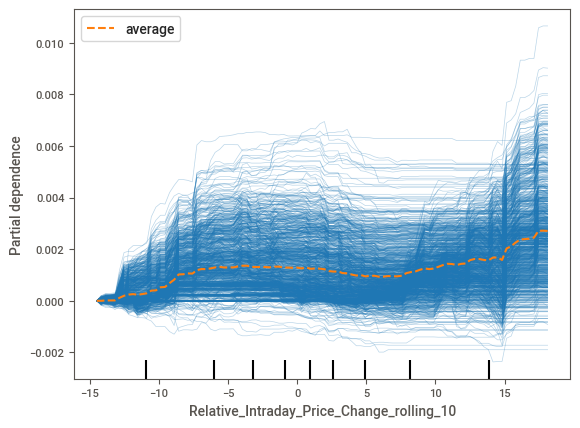

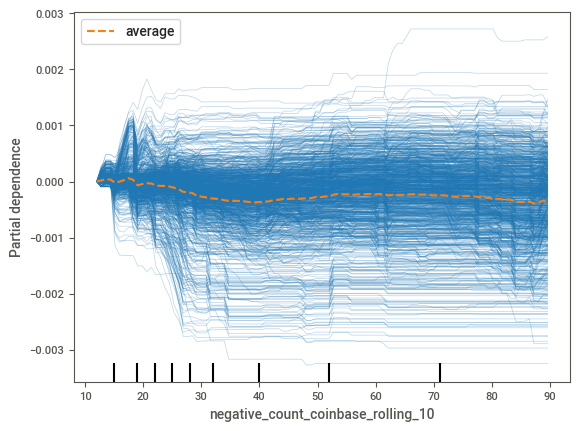

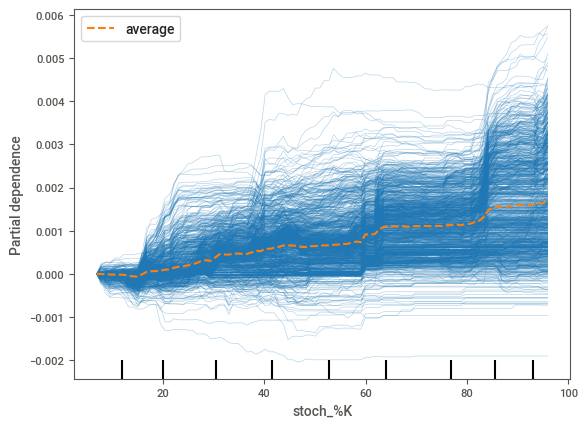

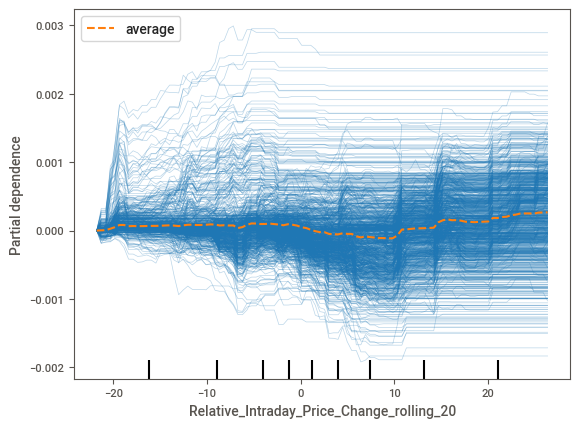

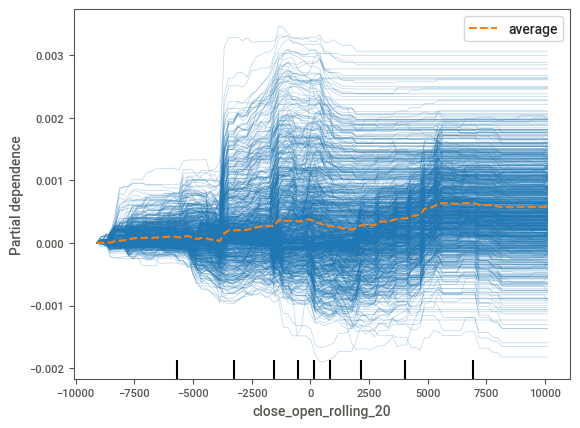

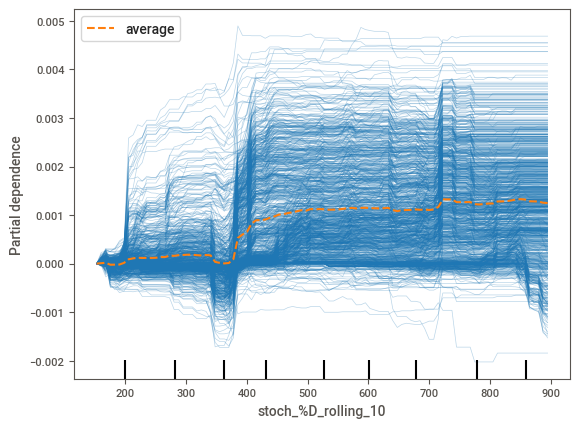

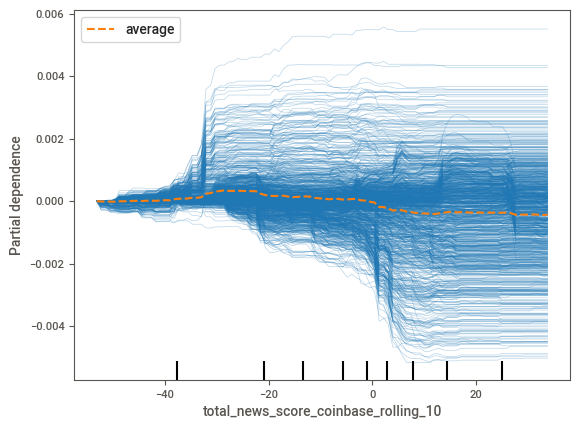

In [8]:
for col in X.columns:
    # Choose the feature of interest
    features = [col]

    # Use PartialDependenceDisplay to display the ICE plot
    PartialDependenceDisplay.from_estimator(model,
                                            X_now[cols],
                                            features,
                                            kind='both', # both plots ICE & PDP
                                            centered=True) # Makes it easier to see trend

### ICE PDP Interpretations

> RSI: Based on the PDP and ICE plots, there appears to be a correlation where as RSI rises, the price of Bitcoin also tends to increase. However, this presents a problem since RSI traditionally signals overbought and oversold conditions for assets. Ideally, one would anticipate RSI to exert both positive and negative influences on the Bitcoin price.

>STOCH_%d: Based on the PDP and ICE plots, there appears to be a inflection point around 50, where bigger values for STOCH%D leads to higher prices for Bitcoin the following day. Similar argument as RSI applies here for unrealistic relationship with BTC price.

>STOCH_%k_rolling_10: Based on the PDP and ICE plots, there appears to be a inflection point around 800, where bigger values for STOCH_%k_rolling_10 leads to higher prices for Bitcoin the following day. Similar argument as RSI applies here for unrealistic relationship with BTC price.

>Relative_Intraday_Price_change_rolling_20: Based on the PDP and ICE plots, there seems to be very little correlation between this feature and the price of Bitcoin. This finding appears somewhat implausible considering it ranks among our top ten most important features. The observed lack of relationship may be attributed to issues of multicollinearity between the input features.

>STOCH_%d: Same as STOCH_%d

>negative_count_coinbase_rolling_10: According to the PDP and ICE plots, there appears to be an inverse relationship between this variable and the prediction of Bitcoin price. This aligns with common sense, as one would anticipate a decline in Bitcoin price corresponding to an increase in negative news coverage about Coinbase, a prominent cryptocurrency exchange.

>close_open_rolling_20: Same as relative_Intraday_Price_change_rolling_20

>STOCH_%D_rolling_10: Same as STOCH_%K_rolling_10

>total_news_score_coinbase_rolling_10: This feature has minimal impact (in terms of magnitue) on the price of the model's Bitcoin prediction.

## ALE (Accumulated Local Effects) Plot

> The ALE plots only consider realistic combinations of the features, so this provides a more realistic sense of how each individual feature affects bitcoin prices (Not guaranteed to be causal).

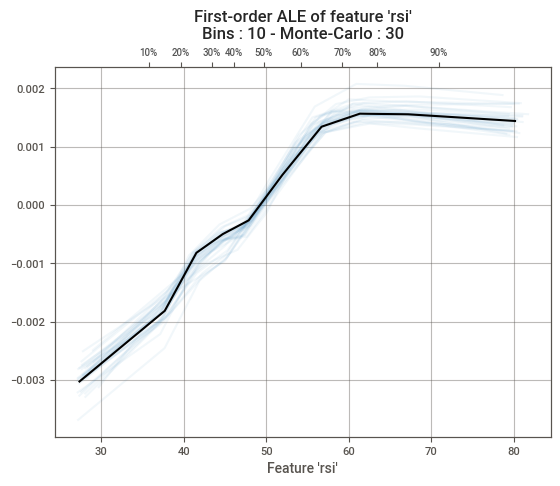

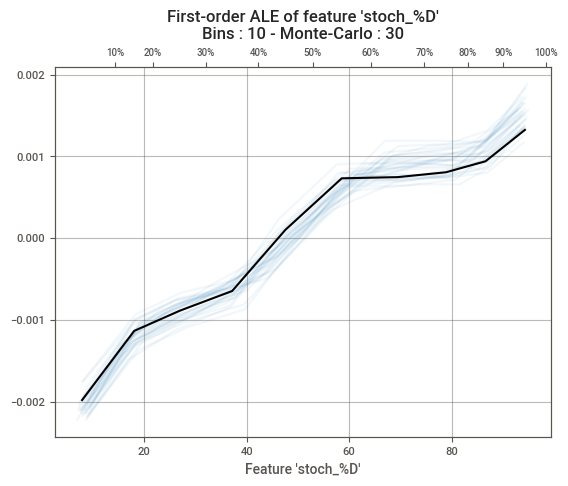

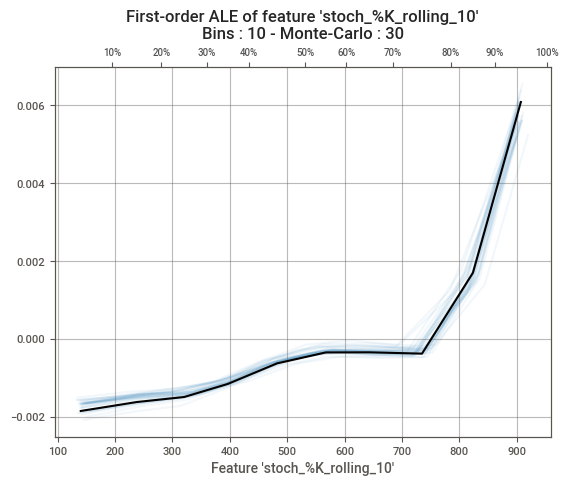

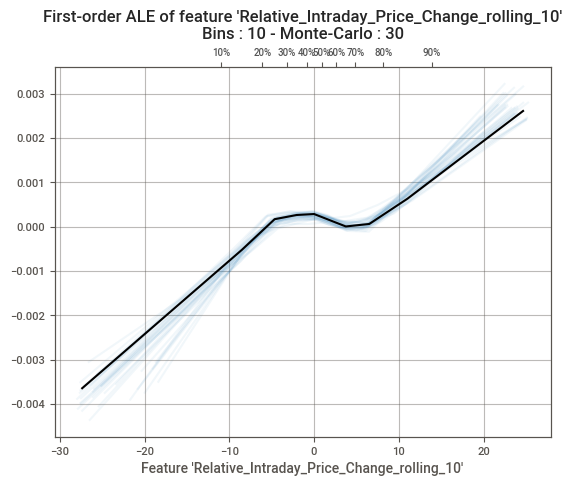

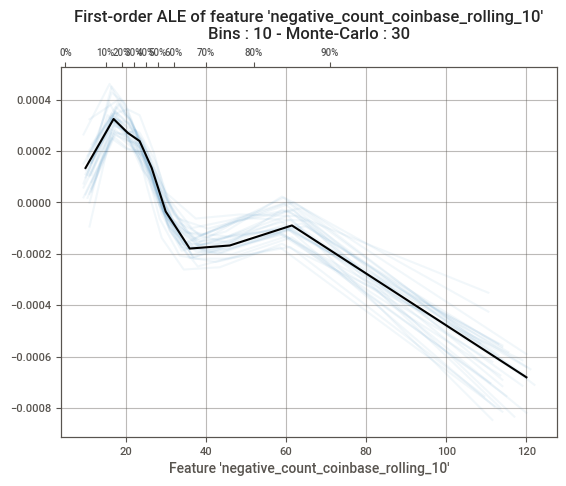

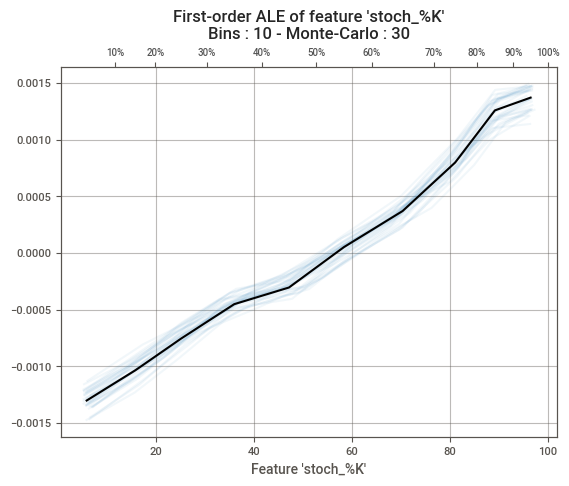

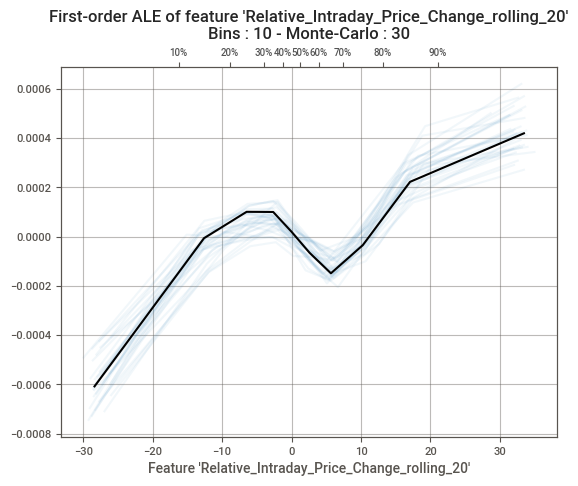

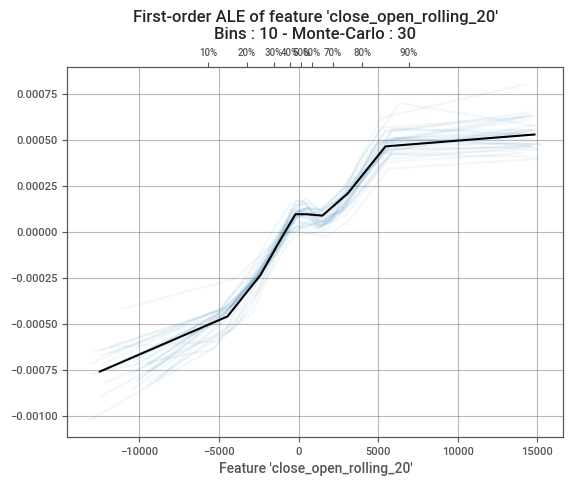

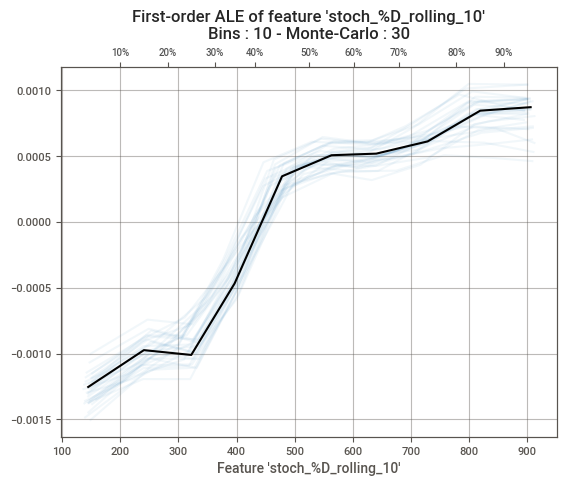

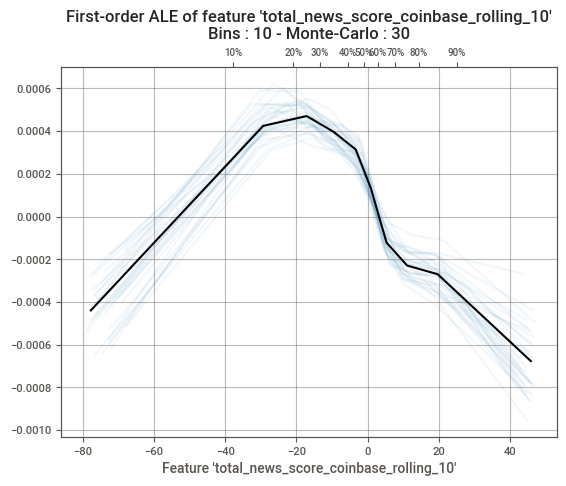

In [9]:
for col in X.columns:
  # Use default parameters for 1D Main Effect ALE Plot
  ale_plot(model, X_now[cols], col, monte_carlo=True, monte_carlo_rep=30, monte_carlo_ratio=0.5)

### ALE Interpretations

>RSI: The ALE plot indicates that the model's Bitcoin price prediction is negatively affected by lower RSI values, whereas higher RSI values positively impact it. Low RSI values indicate oversold conditions, while high values indicate overbought conditions. Our findings suggest that in oversold markets, prices tend to decline further the next day, while the opposite is true for higher RSI values.

>STOCH_%D: The ALE plot indicates that the model's Bitcoin price prediction is negatively affected by lower STOCH_%D values, whereas higher STOCH_%D values positively impact it. Similar overbought and over sold argument as RSI applies here.

>STOCH_%k_rolling_10: The ALE plot indicates that the model's Bitcoin price prediction is negatively affected by lower STOCH_%k_rolling_10 values, whereas higher STOCH_%k_rolling_10 values positively impact it. Similar overbought and over sold argument as RSI applies here.

>Relative_Intraday_Price_change_rolling_20: The ALE plot shows that lower values negatively affect the model's Bitcoin price predictions, while higher values have a positive influence. Medium values seem to have minimal impact. This aligns intuitively, as higher values suggest bullish price movements over the past ten days, whereas lower values indicate the opposite.

>STOCH_%K: Same as STOCH_%D

>negative_count_coinbase_rolling_10: The ALE plot indicates that low values of this feature have a minimal impact on the model's price predictions. However, higher values tend to negatively influence the price. This is intuitive; a small number of negative articles may not signal a decline in Bitcoin prices the next day. In contrast, a substantial increase in negative articles can exert downward pressure on Bitcoin prices.

>close_open_rolling_20: Same as relative_Intraday_Price_change_rolling_20

>STOCH_%D_rolling_10: Same as STOCH_%K_rolling_10

>total_news_score_coinbase_rolling_10: This feature has minimal impact (in terms of magnitue) on the price of the model's Bitcoin prediction.

## Conclusion

In this notebook, we successfully developed a robust Random Forest model that predicts the 15-day moving average (15DAR) of Bitcoin prices with an accuracy of around 75%. This work builds on a previous project that demonstrated how the 15DAR can effectively forecast tomorrow's Bitcoin price movement (either bullish or bearish). We utilized explainable AI techniques, including ICE, PDP, and ALE plots, to analyze both global and local feature impacts on the model's predictions. Key technical indicators—such as RSI, stochastic oscillator values, and relative intraday price changes—along with sentiment analysis derived from news articles, significantly influenced Bitcoin price movements. This approach provides investors with insights into the model's reasoning.